In [1]:
import sys
sys.path.append('../')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from low_rank_rnns.modules import *
from low_rank_rnns import romo, clustering, helpers, rankone, ranktwo

In [2]:
helpers.setup_matplotlib(release=True)

In [3]:
def time_mapping(t):
    return t * romo.deltaT / 1000

In [4]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
fixed_delay = 50
end_task = fixed_delay + 30
x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000);
net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, train_wi=False, train_wo=False, rank=2);
net.load_state_dict(torch.load('../models/romo_rank2_500.pt', map_location='cpu'))
net.svd_reparametrization()
print(romo.fpairs_global)

[(34, 10), (26, 10), (27, 11), (28, 12), (29, 13), (30, 14), (31, 15), (32, 16), (33, 17), (34, 18), (18, 10), (19, 11), (20, 12), (21, 13), (22, 14), (23, 15), (24, 16), (25, 17), (26, 18), (27, 19), (28, 20), (29, 21), (30, 22), (31, 23), (32, 24), (33, 25), (34, 26), (10, 18), (11, 19), (12, 20), (13, 21), (14, 22), (15, 23), (16, 24), (17, 25), (18, 26), (19, 27), (20, 28), (21, 29), (22, 30), (23, 31), (24, 32), (25, 33), (26, 34), (10, 26), (11, 27), (12, 28), (13, 29), (14, 30), (15, 31), (16, 32), (17, 33), (18, 34), (10, 34)]


In [5]:
loss_orig, acc_orig = romo.test_romo(net, x_val, y_val, mask_val)

In [6]:
m1 = net.m[:,0].detach().numpy()
n1 = net.n[:,0].detach().numpy()
m2 = net.m[:,1].detach().numpy()
n2 = net.n[:,1].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()
vectors = [-wi, n1, n2, m1, m2, -wo]

# Traces

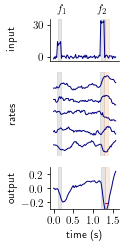

In [9]:
figsize_default = plt.rcParams['figure.figsize']
figsize = (.7 * .7 * figsize_default[0], 2 * .7 * figsize_default[1])

stim2_begin = romo.stim1_end + fixed_delay
stim2_end = stim2_begin + romo.stimulus2_duration_discrete
end_decision = stim2_end + romo.decision_duration_discrete
fpair1 = (30, 12)
net.noise_std = noise_std
cmap = plt.get_cmap('jet')
color = cmap(0)
x1, y1, mask1, _, _, _ = romo.generate_data(1, fpairs=[(25, 30)], fraction_validation_trials=0., 
                                            delay_discrete=fixed_delay)
outp1, trajectories = net.forward(x1[:, :end_task, :], return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates = np.tanh(trajectories)
time = time_mapping(np.arange(x1.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 2, 1]})
x1 = x1.squeeze().numpy()
ax[0].plot(time[:end_task], x1[:end_task], lw=1, c=color)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), alpha=.2, color='gray')
ax[0].axvspan(time_mapping(stim2_begin), time_mapping(stim2_end), alpha=.2, color='gray')
ax[0].axvspan(time_mapping(stim2_end), time_mapping(end_decision), alpha=.2, color='sandybrown')
ax[0].set(yticks=[0, .3], xticks=[], ylabel='input', yticklabels=['$0$', '$30$'])
ax[0].text(s='$f_1$', x=.09, y=.4)
ax[0].text(s='$f_2$', x=1.1, y=.4)

n_neurons = 5
neurons = np.random.choice(hidden_size, n_neurons, replace=False)
extracted_act1 = rates[:, neurons]
helpers.plot_rates_single_neurons(extracted_act1, offset=.3, deltaT=romo.deltaT, colors=[color] * n_neurons,
                                       figsize=matplotlib.rcParams['figure.figsize'], ax=ax[1])
ax[1].axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), alpha=.2, color='gray')
ax[1].axvspan(time_mapping(stim2_begin), time_mapping(stim2_end), alpha=.2, color='gray')
ax[1].axvspan(time_mapping(stim2_end), time_mapping(end_decision), alpha=.2, color='sandybrown')
ax[1].set(ylabel='rates', xticks=[], yticks=[])
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)


ax[2].plot(time_mapping(np.arange(outp1.shape[1])), outp1[0,:,0].detach().numpy(), color=color, zorder=30, lw=1)
y1 = y1.squeeze().numpy()
ax[2].plot(time_mapping(np.arange(stim2_end, end_decision)), y1[stim2_end:end_decision], color='r', zorder=20)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), alpha=.2, color='gray')
ax[2].axvspan(time_mapping(stim2_begin), time_mapping(stim2_end), alpha=.2, color='gray')
ax[2].axvspan(time_mapping(stim2_end), time_mapping(end_decision), alpha=.2, color='sandybrown')
ax[2].set(yticks=[-.2, 0, .2], xticks=[0, .5, 1, 1.5], ylim=(-.3, .3), ylabel='output', xlabel='time (s)')

fig.align_ylabels()
#plt.savefig('figures/3_romo_traces.pdf', bbox_inches='tight')

# Connectivity

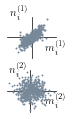

In [12]:
color = 'lightslategray'
figsize_default = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(2, 1, figsize=(figsize_default[0] / 2 * .7, figsize_default[1] * .7))
helpers.center_axes(ax[0])
ax[0].scatter(m2, n2, c=color, s=1, zorder=30)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)
ax[0].set_xlabel('$m_i^{(1)}$', horizontalalignment='right', x=1.2)
ax[0].set_ylabel('$n_i^{(1)}$', horizontalalignment='right', y=.9, rotation='horizontal')

helpers.center_axes(ax[1])
ax[1].scatter(m1, n1, c=color, s=.7, zorder=30)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('$m_i^{(2)}$', horizontalalignment='right', x=1.2)
ax[1].set_ylabel('$n_i^{(2)}$', horizontalalignment='right', y=.8, rotation='horizontal')

plt.subplots_adjust(hspace=.3)

#plt.savefig('figures/3_romo_scatters.pdf', bbox_inches='tight')

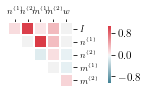

In [15]:
lsize = 9
rescaled_vectors = [-wi, n2, n1, m2, m1, wo / sqrt(hidden_size)]
ov = helpers.overlap_matrix(rescaled_vectors)
labels = ['$I$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$']
bound = np.max((np.abs(np.min(ov)), np.abs(np.max(ov))))
fig, ax = plt.subplots(figsize=(2.1, 2.1))
helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=.5, figsize=(4, 3), cbar_pad=.3, ax=ax)
ax.set_xticks(np.array(list(range(len(labels) - 1))) + .5)
ax.set_xticklabels(labels[1:])
ax.set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax.set_yticklabels(labels[:-1])
ax.xaxis.set_tick_params(labelsize=lsize)
ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
#plt.savefig('figures/3_romo_overlap_matrix.pdf', bbox_inches='tight')

# Dynamics

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Use the colorbar set_ticks() method instead.


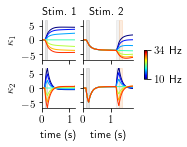

In [18]:
f1s = list(range(10, 35, 4))
f2 = 20
net.noise_std = 0
delay = 1000 // 20
time1 = time_mapping(delay + 10)
time2 = time_mapping(end_task + 10)
fig, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [time1 / time2, 1]}, figsize=(.65 * 2.5, .65*2.5))

cmap = plt.get_cmap('jet')
for i, f1 in enumerate(f1s):
    input_c, target_c, mask_c, _, _, _ = romo.generate_data(1, fpairs=[(f1, f2)], std=0., 
                                                           fraction_validation_trials=0.,
                                                           delay_discrete=delay)
    output_c, activations = net.forward(input_c, return_dynamics=True)
    activations = activations.detach().numpy().squeeze()
    rates = np.tanh(activations)
    ## INVERSION HERE
    kappa1 = rates @ n2 / sqrt(hidden_size)
    kappa2 = rates @ n1 / sqrt(hidden_size)
    seq_len = input_c.shape[1] + 1
    axes[0][0].plot(time_mapping(np.arange(len(kappa1))), kappa1, label=str(f1), c=cmap(i/len(f1s)), lw=1)
    axes[1][0].plot(time_mapping(np.arange(len(kappa1))), kappa2, label=str(f1), c=cmap(i/len(f1s)), lw=1)
    
for ax in (axes[0][0], axes[1][0]):
    ax.set(xlim=(0, time1), yticks=[-5, 0, 5], xticks=[0, 1], ylim=(-7, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), color='gray', alpha=.2)

f1 = 30
f2s = list(range(10, 35, 4))
for i, f2 in enumerate(f2s):
    input_c, target_c, mask_c, _, _, _ = romo.generate_data(1, fpairs=[(f1, f2)], std=0., 
                                                           fraction_validation_trials=0.,
                                                           delay_discrete=delay)
    output_c, activations = net.forward(input_c, return_dynamics=True)
    activations = activations.detach().numpy().squeeze()
    rates = np.tanh(activations)
    ## INVERSION HERE
    kappa1 = rates @ n2 / sqrt(hidden_size)
    kappa2 = rates @ n1 / sqrt(hidden_size)
    seq_len = input_c.shape[1] + 1
    axes[0][1].plot(time_mapping(np.arange(len(kappa1))), kappa1, label=str(f2), c=cmap(i/len(f2s)), lw=1)
    axes[1][1].plot(time_mapping(np.arange(len(kappa1))), kappa2, label=str(f2), c=cmap(i/len(f2s)), lw=1)

for ax in (axes[0][1], axes[1][1]):
    ax.set(xlim=(0, time2), yticks=[-5, 0, 5], xticks=[0, 1], ylim=(-7, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), color='gray', alpha=.2)
    stim2_beg = romo.stim1_end + delay
    stim2_end = stim2_beg + romo.stimulus2_duration_discrete
    ax.axvspan(time_mapping(stim2_beg), time_mapping(stim2_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_end), time_mapping(stim2_end + romo.decision_duration_discrete), 
               color='sandybrown', alpha=.2)
    
axes[0][0].set_xticklabels([''] * 3)
axes[0][0].set_ylabel('$\kappa_1$')
axes[0][1].set_xticklabels([''] * 3)
axes[0][1].set_yticklabels([''] * 3)
axes[1][0].set_ylabel('$\kappa_2$')
axes[1][0].set_xlabel('time (s)')
axes[1][1].set_yticklabels([''] * 3)
axes[1][1].set_xlabel('time (s)')
axes[0][0].text(s='Stim. 1', x=.65, y=9, horizontalalignment='center')
axes[0][1].text(s='Stim. 2', x=.85, y=9, horizontalalignment='center')

w = .02
h = .25
ax_cbar = fig.add_axes((1, .5 - h/2, w, h))
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
ax_cbar.set(yticks=[0, 1], yticklabels=['$10$ Hz', '$34$ Hz'])

plt.show()
#fig.savefig('figures/3_romo_kappas.pdf', bbox_inches='tight')

# Resampling

In [22]:
accs = []

# Resample a few networks
n_samples = 10
for _ in range(n_samples):  
    net2 = clustering.to_support_net(net, np.zeros(hidden_size))
    loss, acc = romo.test_romo(net2, x_val, y_val, mask_val)
    accs.append(acc)
    
net_rec = SupportLowRankRNN_withMask(1, 1024, 1, noise_std, alpha, rank=2, n_supports=1, gaussian_basis_dim=3)
net_rec.load_state_dict(torch.load('../models/romo_rank2_reconstructed_1024.pt'))
accs_rec = []
for _ in range(n_samples):  
    net_rec.resample_basis()
    loss, acc = romo.test_romo(net_rec, x_val, y_val, mask_val)
    accs_rec.append(acc)

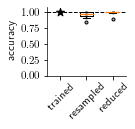

In [23]:
figsize_orig = plt.rcParams['figure.figsize']
helpers.boxplot_accuracies([acc_orig, accs, accs_rec], labels=['trained', 'resampled', 'reduced'],
                          figsize=(2*.7, 1.8*.7))
#plt.savefig('figures/3_romo_resampling.pdf', bbox_inches='tight')

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Use the colorbar set_ticks() method instead.
  


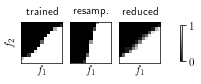

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(2.5, 5))
romo.psychometric_matrices(net, binarize=1, ax=ax[0], ylabel=True)
ax[0].set_title('trained')
romo.psychometric_matrices(net2, binarize=1, ax=ax[1])
ax[1].set_title('resamp.')
romo.psychometric_matrices(net_rec, binarize=1, ax=ax[2])
ax[2].set_title('reduced')

w = .01
h = .1
ax_cbar = fig.add_axes((1.01, .5 - h/2, w, h))
cmap = plt.get_cmap('gray')
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
ax_cbar.set(yticks=[0, 1])
#plt.savefig('figures/3_romo_psycho_matrix.pdf', bbox_inches='tight')